In [1]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy
from sklearn.decomposition import PCA, FastICA

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

In [2]:
path_to_hpc = '/Users/amir/Desktop/for Abdel/OS Basic/1/HC/post_trial5_2017-09-27_14-18-24/HPC_100_CH46.continuous.mat'
path_to_states = '/Users/amir/Desktop/for Abdel/OS Basic/1/HC/post_trial5_2017-09-27_14-18-24/post_trial5_2017-09-27_14-18-24-states.mat'

In [3]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)

There was 0 in the dataset


In [4]:
def extract_pt_intervals(lfp, hypno, fs=2500):
  targetFs = 500
  n_down = fs/targetFs
  start, end = get_start_end(hypno=hypno, sleep_state_id=5)
  rem_interval = nap.IntervalSet(start=start, end=end)
  fs = int(n_down*targetFs)
  t = np.arange(0, len(lfpHPC)/fs, 1/fs)
  lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

  # Detect phasic intervals
  lfpHPC_down = preprocess(lfpHPC, n_down)
  phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

  # Create phasic REM IntervalSet
  start, end = [], []
  for rem_idx in phREM:
    for s, e in phREM[rem_idx]:
      start.append(s/targetFs)
      end.append(e/targetFs)
  phasic_interval = nap.IntervalSet(start, end)

  tonic_interval = rem_interval.set_diff(phasic_interval)

  return phasic_interval, tonic_interval, lfp

In [5]:
config = emd.sift.SiftConfig.from_yaml_file('/Users/amir/Desktop/for Abdel/OS Basic/emd_masksift_CA1_config_2500.yml')

In [6]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

In [7]:
phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)

In [8]:
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)

In [9]:
def get_cycle_data(imf5, fs=2500):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [10]:
def extract_cycle_info(imfs, imf_frequencies):

  all_FPPs = []
  all_cycles_se =[]
  all_cycles_ctrl = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    ctrl = emd.cycles.get_control_points(imf[:, 5], cycle_data['cycles'], mode='augmented')
    cycle_ctrls = get_cycle_ctrl(ctrl, subset_indices)
    all_cycles_ctrl.append(cycle_ctrls)
    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    all_cycles_se.append(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

  return all_cycles_ctrl, all_cycles_se, all_FPPs

In [17]:
all_phasic_cycle_ctrls, all_phasic_cycles_se, all_phasic_FPPs = extract_cycle_info(phasic_imfs, phasic_imfs_freqs)
all_tonic_cycle_ctrls, all_tonic_cycles_se, all_tonic_FPPs = extract_cycle_info(tonic_imfs, tonic_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs 

In [15]:
frequencies = np.arange(15, 141, 1)
angles = np.linspace(-180, 180, 19)

In [18]:
FPP = all_phasic_FPPs[1]
all_cycles_inds = all_phasic_cycles_se[0]
all_cycles_ctrl = all_phasic_cycle_ctrls[0]
imf = phasic_imfs[0]
firstRemLFP = rem_lpf[0]

In [32]:
len(imf[:, 5])

8550

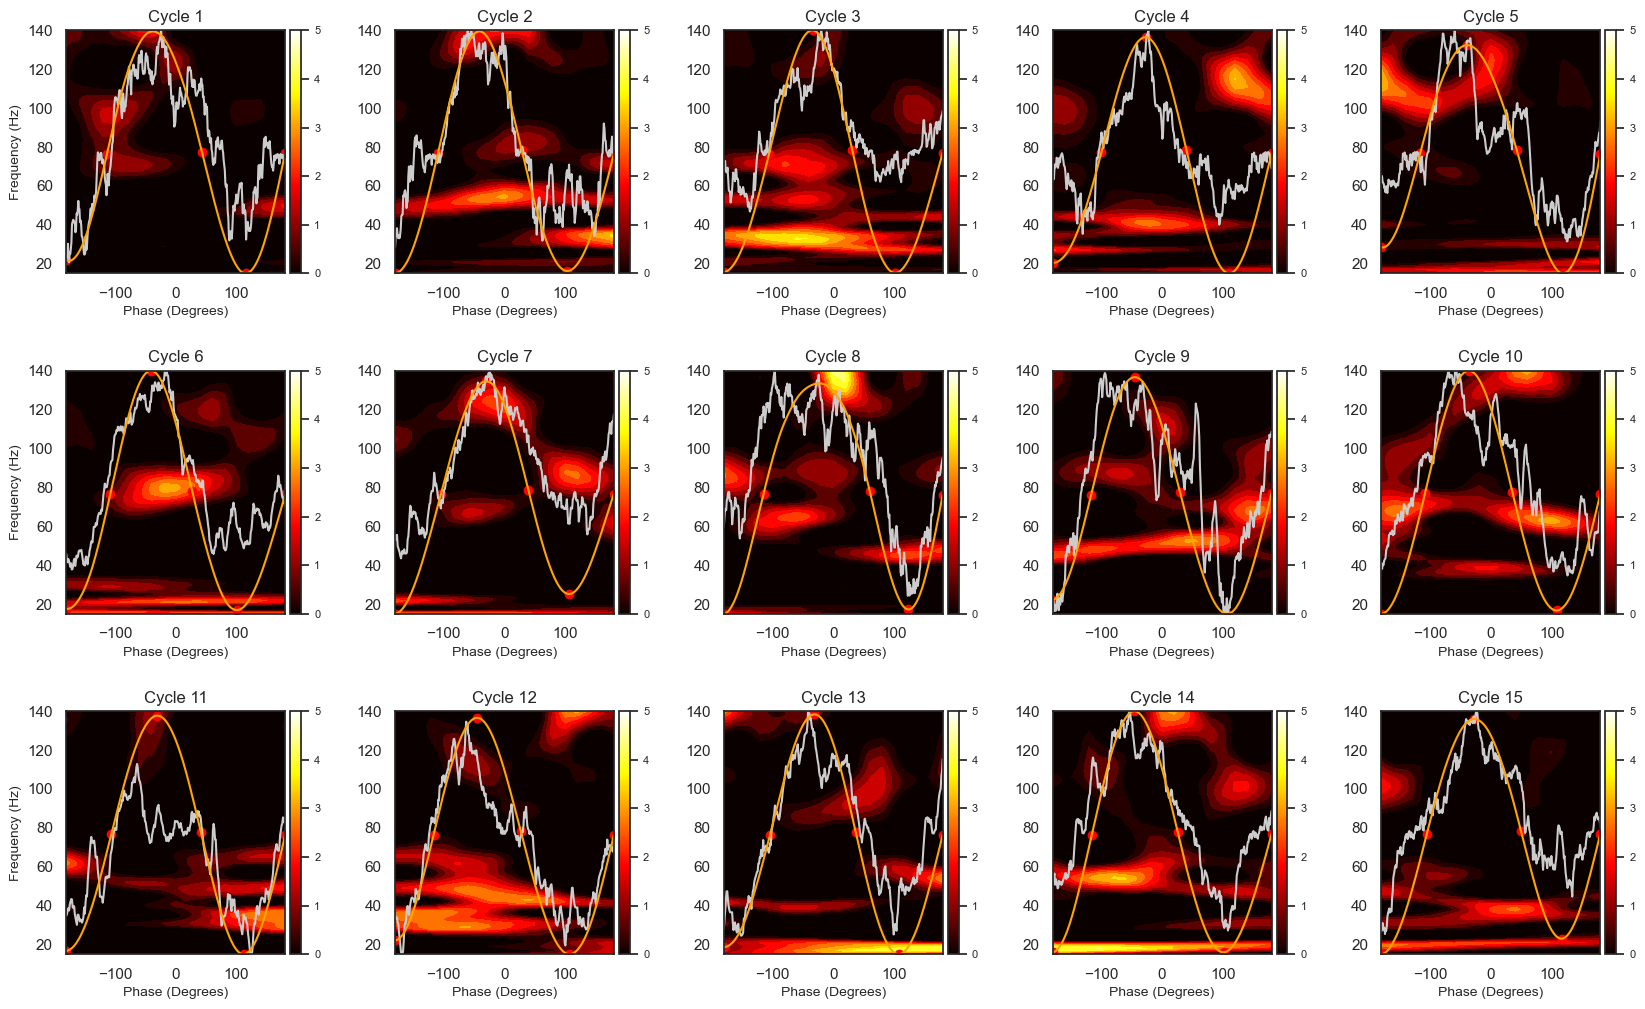

In [53]:
n_rows, n_cols = 3, 5
max_plots = n_rows * n_cols

vmin = 0
vmax = 5

n_levels = 20
levels = np.linspace(np.min(FPP), np.max(FPP), n_levels)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]

    im = ax.contourf(angles, frequencies, FPP[ii], levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)

    ax.set_title(f"Cycle {ii+1}", fontsize=12)
    
    xinds = np.arange(len(all_cycles_inds[ii]))
    raw_lfp = firstRemLFP[all_cycles_inds[ii]]
    theta_part = imf[all_cycles_inds[ii], 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    ctrl_points_x = np.interp(all_cycles_ctrl[ii], np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[all_cycles_ctrl[ii]] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax, ticks=range(vmin, vmax+5, 5))
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=8)
plt.show()

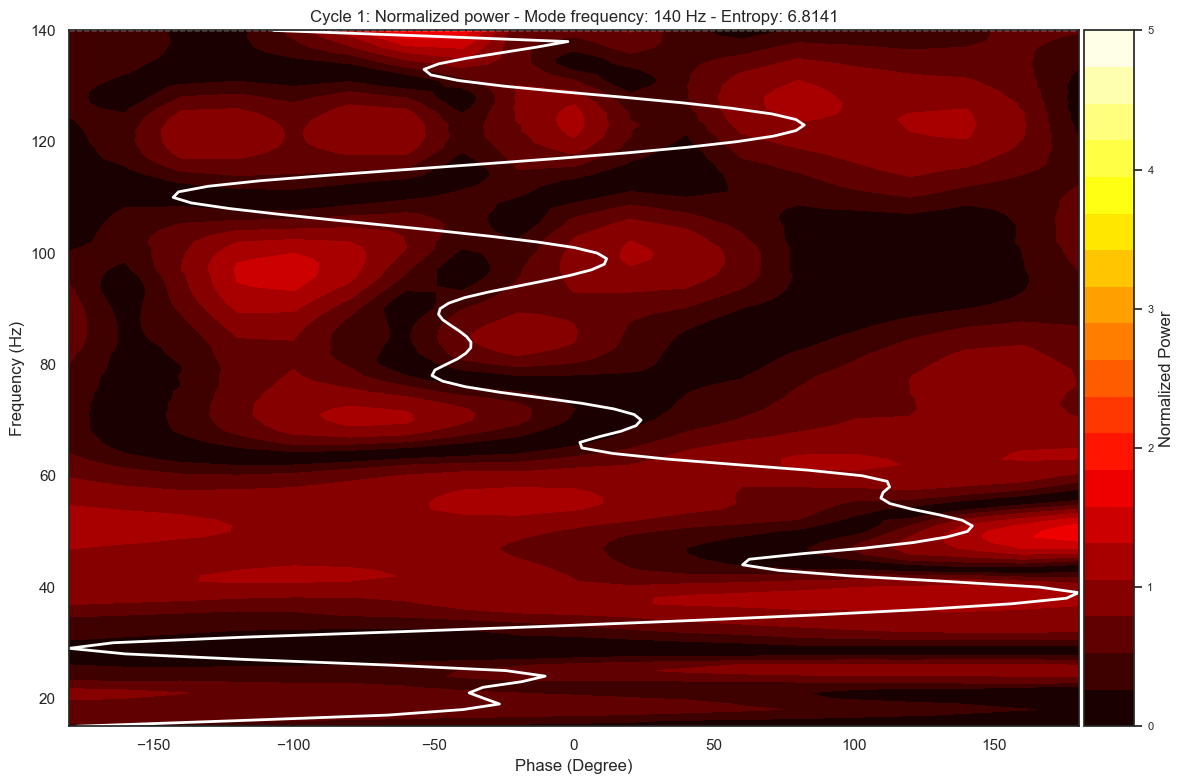

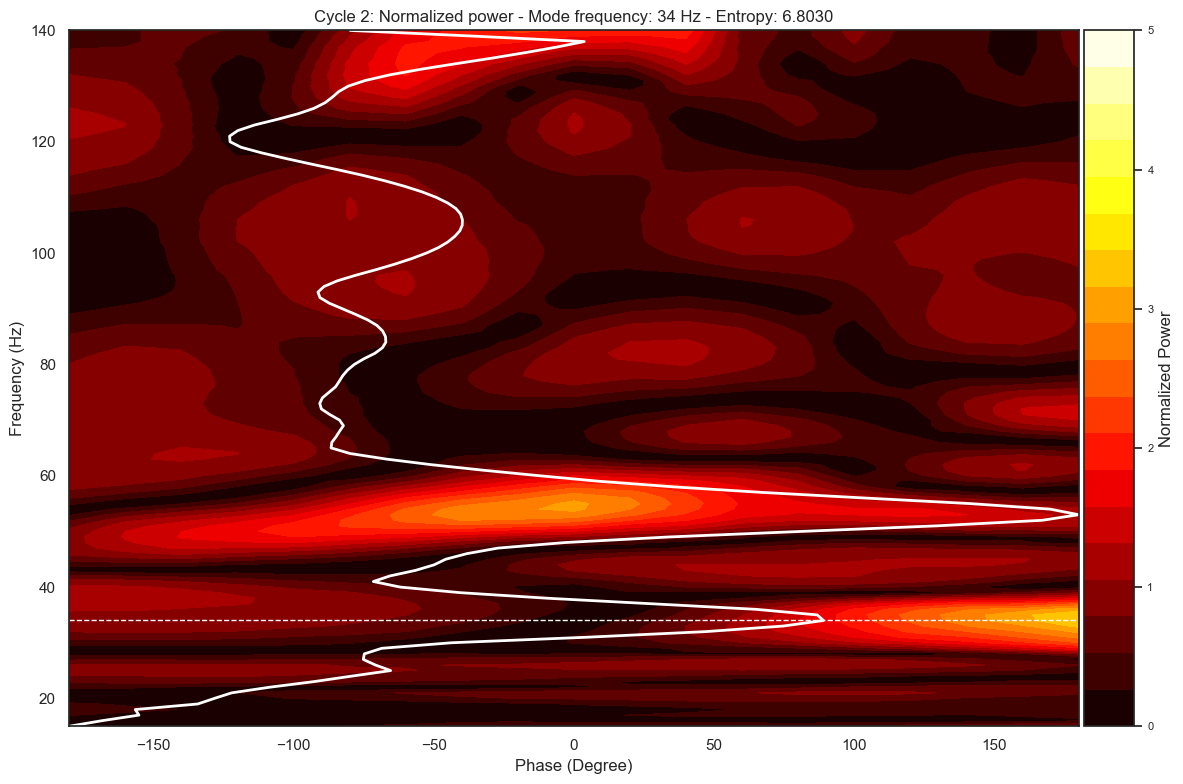

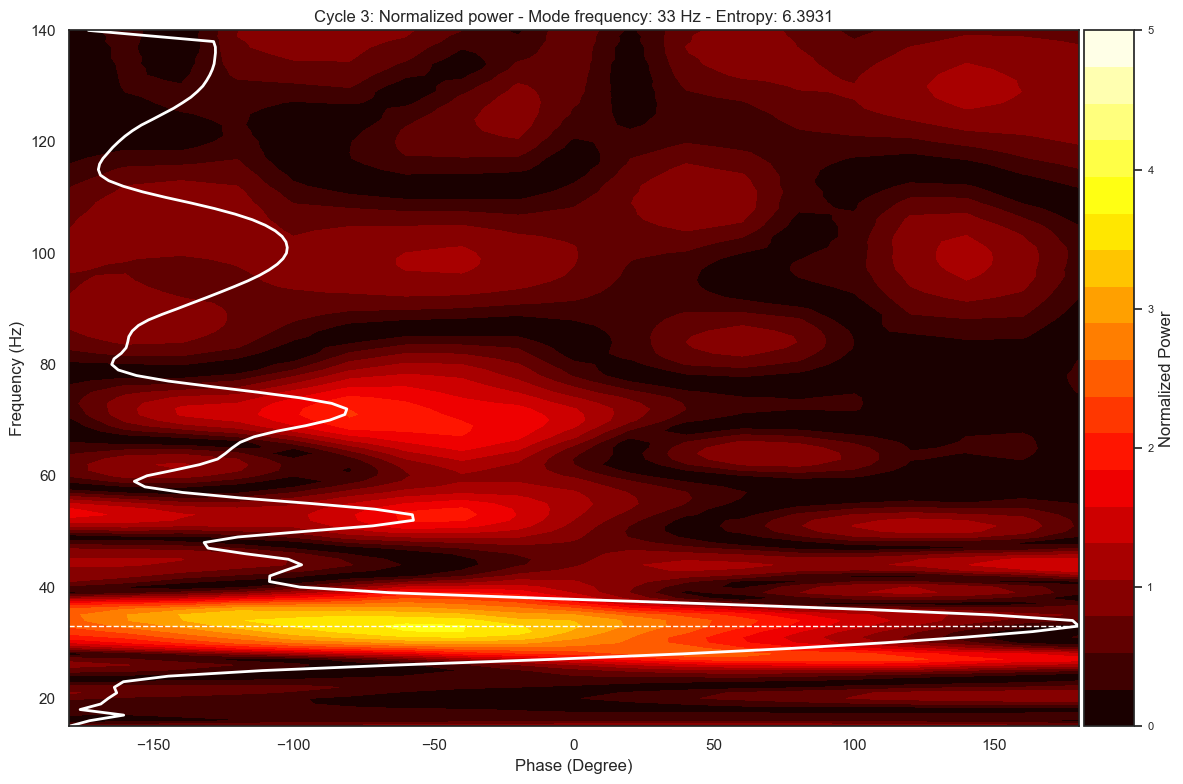

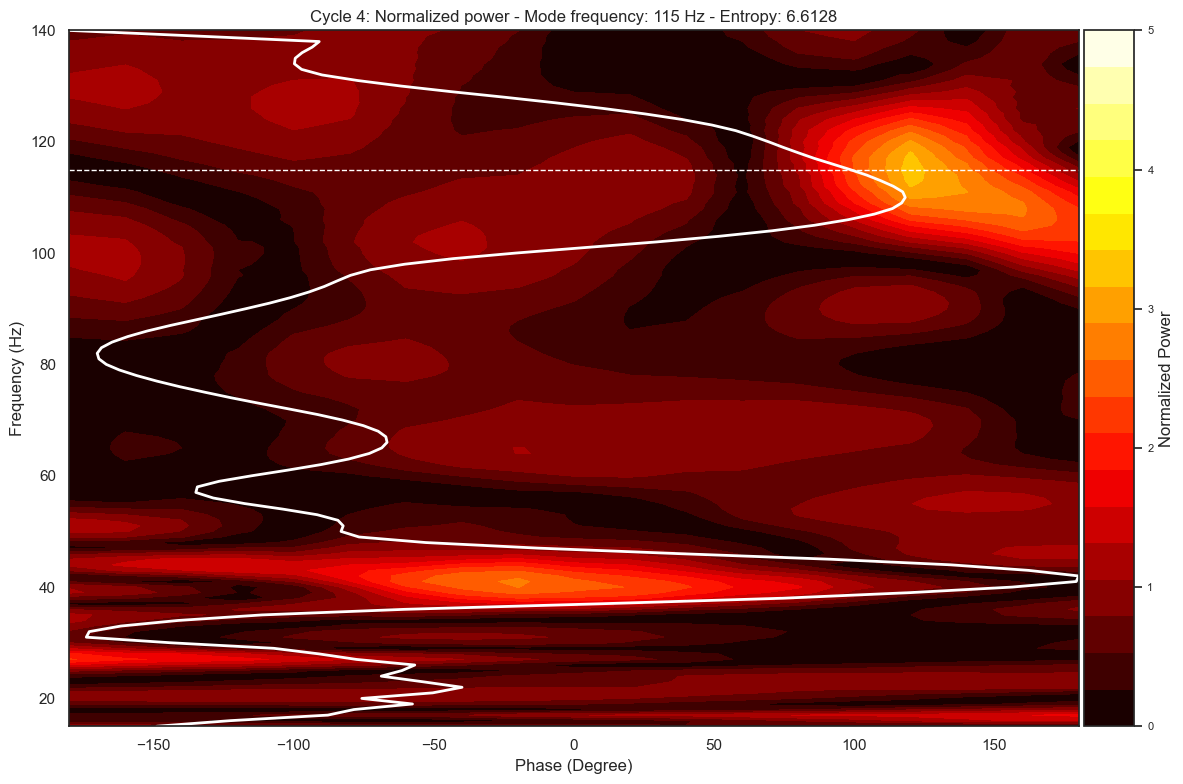

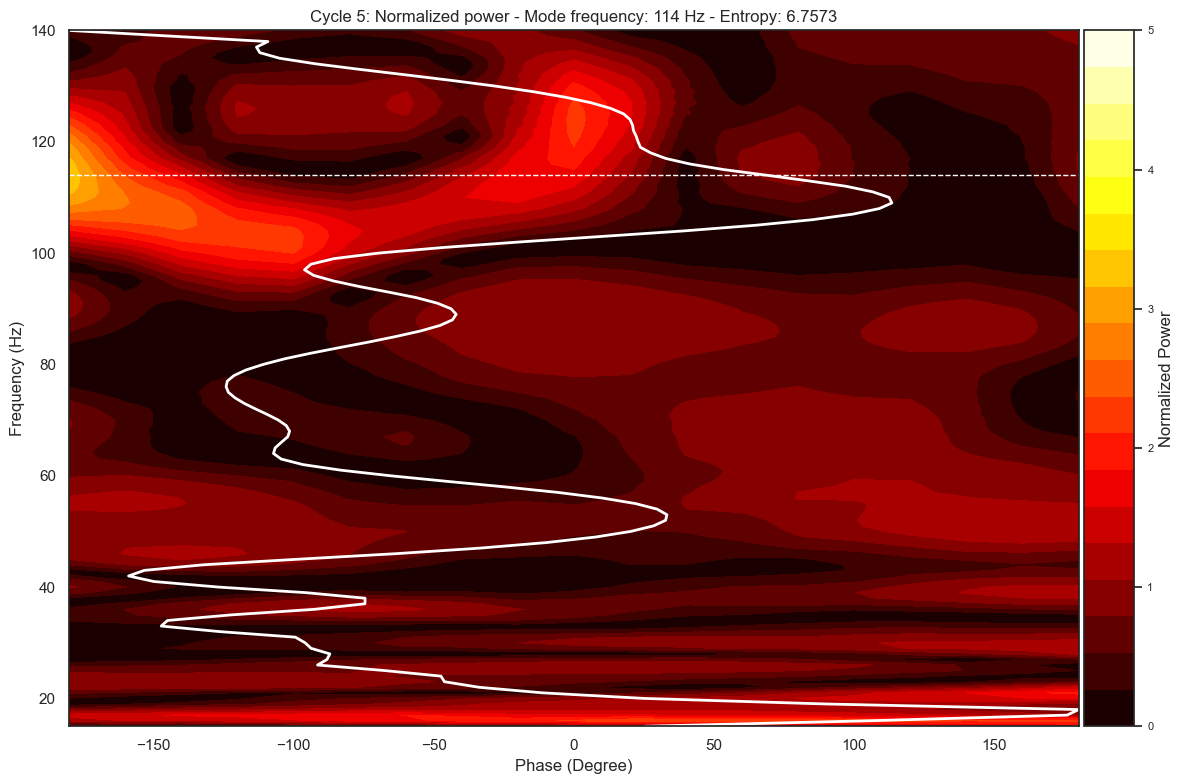

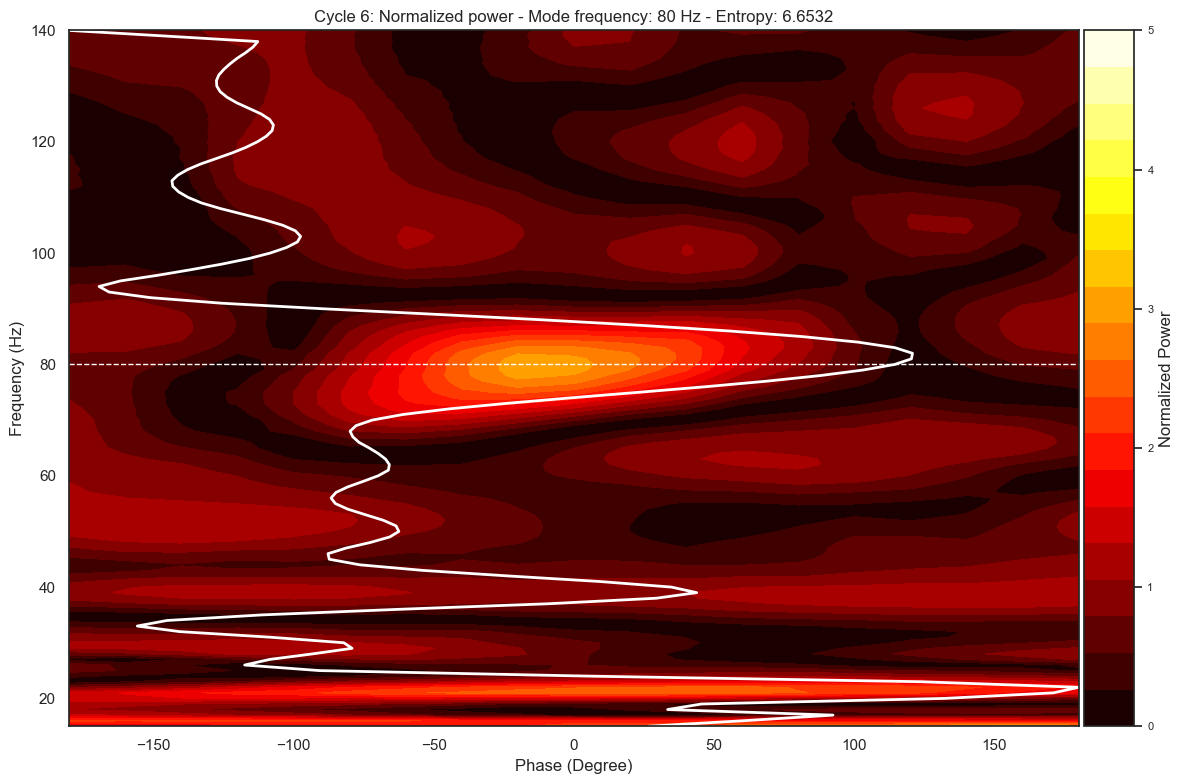

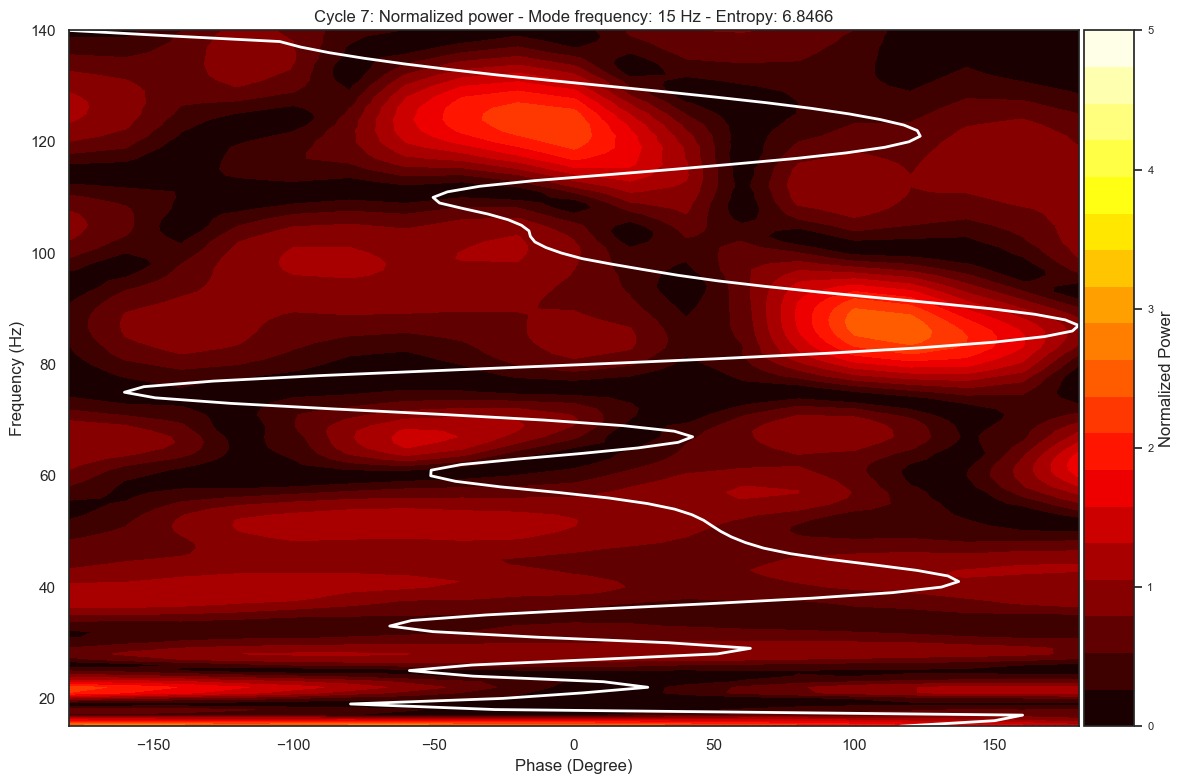

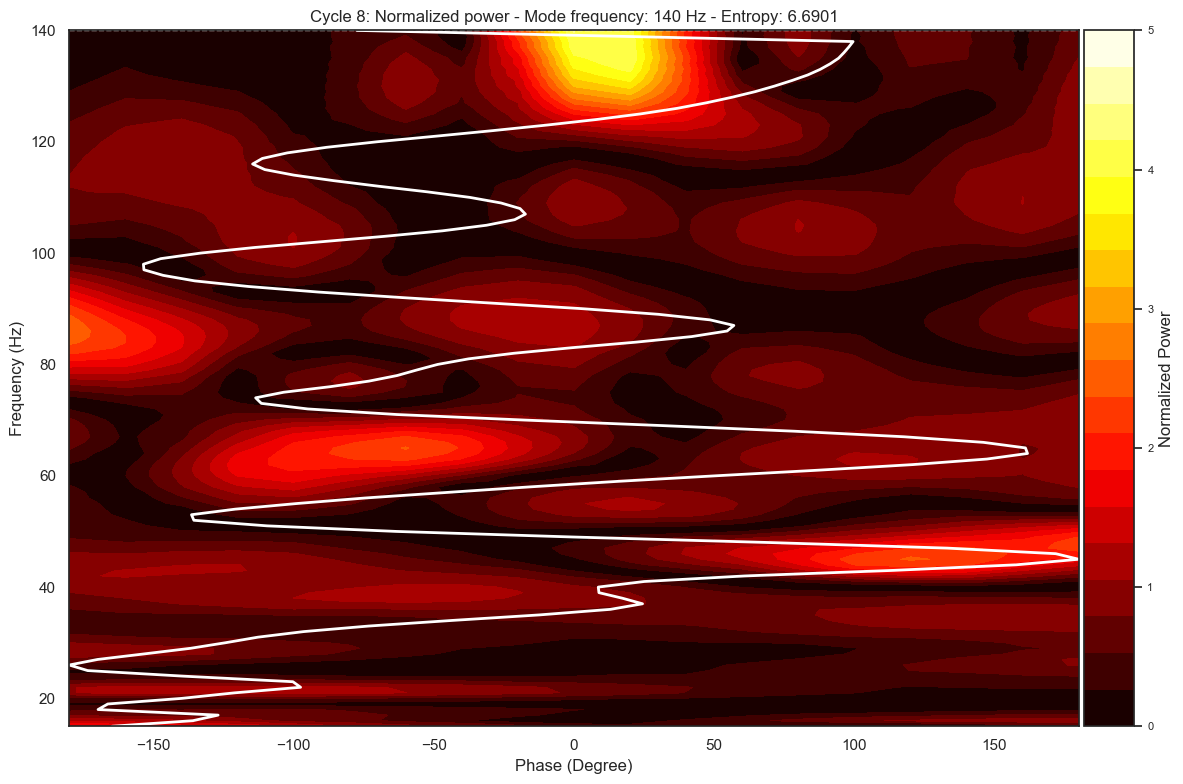

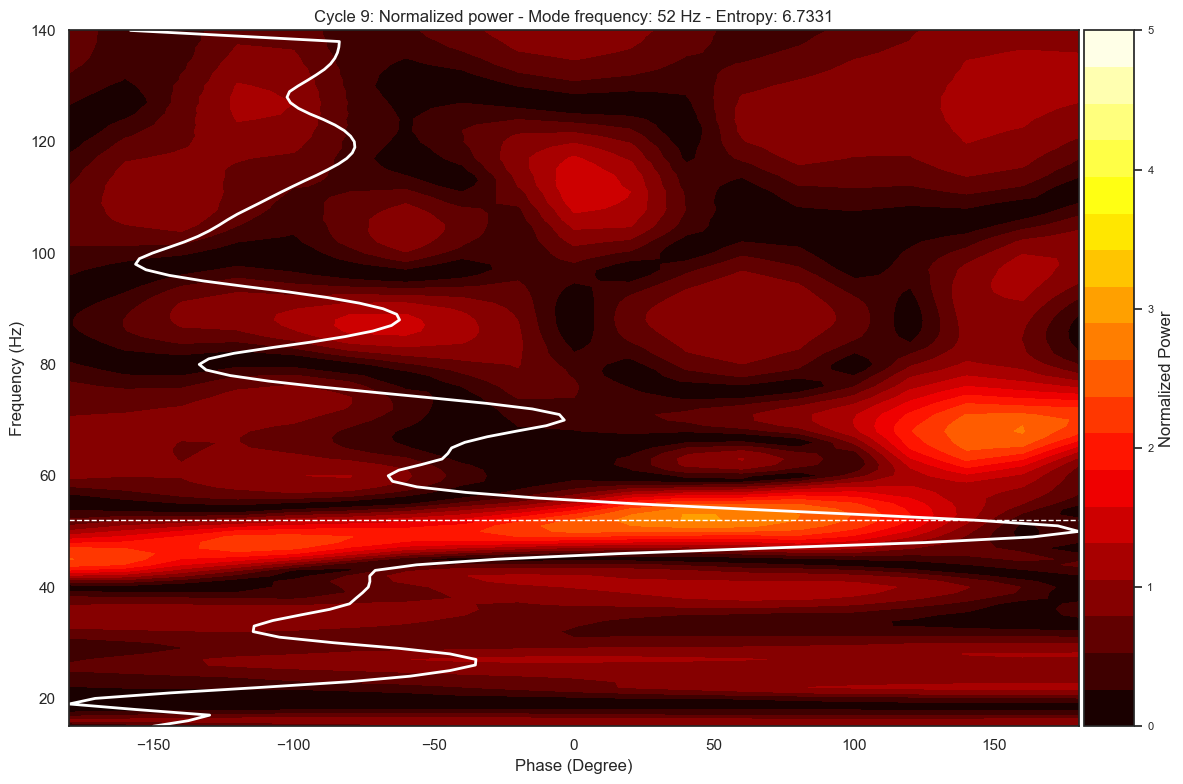

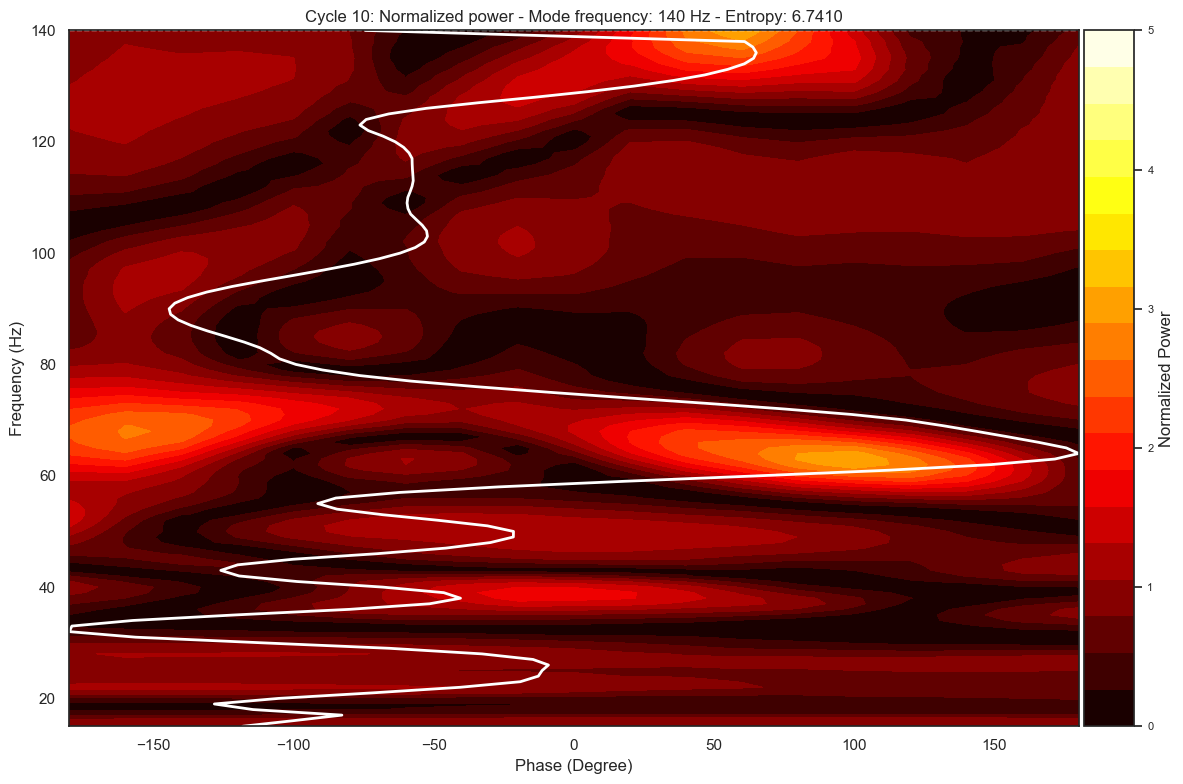

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

vmin = 0
vmax = 5

for i in range(10):  
    angles = np.linspace(-180, 180, 19)
    fpp2 = FPP[i]  
    fpp2 = np.abs(fpp2)

    normalized_fpp2 = fpp2 / np.sum(fpp2)

    n_levels = 20
    levels = np.linspace(vmin, vmax, n_levels) 

    avg_fpp2 = np.sum(fpp2, axis=1)

    window_size = 5  
    smoothed_avg_fpp = np.convolve(avg_fpp2, np.ones(window_size)/window_size, mode='same')
    dist_smoothed_avg_fpp = smoothed_avg_fpp / np.sum(smoothed_avg_fpp)

    smoothed_avg_fpp_norm = (smoothed_avg_fpp - np.min(smoothed_avg_fpp)) / (np.max(smoothed_avg_fpp) - np.min(smoothed_avg_fpp))

    max_index = np.unravel_index(np.argmax(normalized_fpp2, axis=None), normalized_fpp2.shape)
    mode_frequency = frequencies[max_index[0]]
    mode_angle = angles[max_index[1]]

    shannon_entropy = entropy(smoothed_avg_fpp_norm.flatten(), base=2)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))

    contour = ax.contourf(angles, frequencies, fpp2, levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(contour, cax=cax)

    cbar.set_ticks(np.linspace(vmin, vmax, 6))  

    cbar.set_label('Normalized Power')
    cbar.ax.tick_params(labelsize=8)

    scaled_profile = smoothed_avg_fpp_norm * (angles[-1] - angles[0]) + angles[0]
    ax.plot(scaled_profile, frequencies, color='white', linewidth=2)

    ax.axhline(mode_frequency, color='white', linestyle='--', linewidth=1)

    ax.set_xlabel('Phase (Degree)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlim(angles[0], angles[-1])
    ax.set_ylim(frequencies[0], frequencies[-1])

    ax.set_title(f"Cycle {i+1}: Normalized power - Mode frequency: {int(mode_frequency)} Hz - Entropy: {shannon_entropy:.4f}")

    plt.tight_layout()
    plt.savefig(f"cycle_{i+1}_avg_spectrogram_plot.svg", format='svg')
    plt.show()

In [54]:
avg_FPP = np.mean(FPP, axis=0)

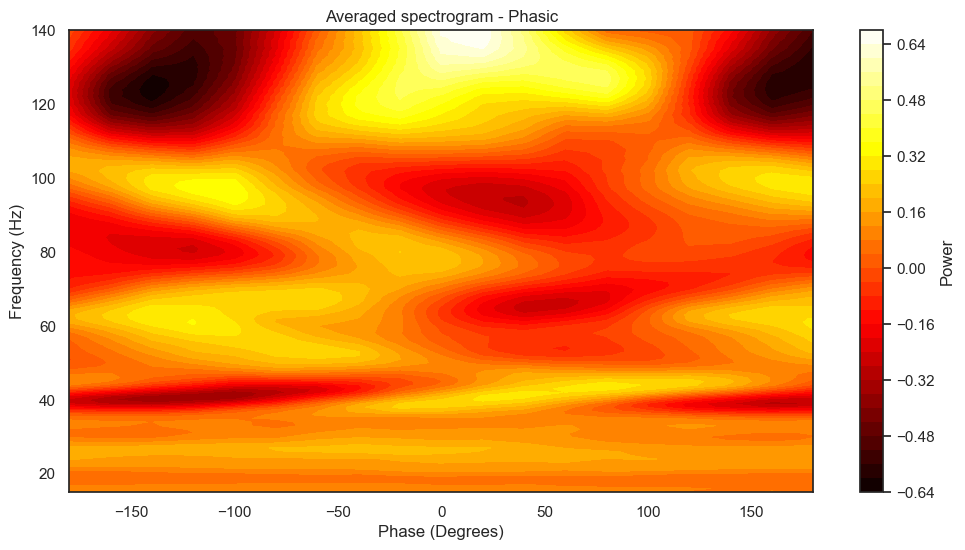

In [55]:
plt.figure(figsize=(12, 6))

plt.contourf(angles, frequencies, avg_FPP, 40, cmap='hot')

plt.xlabel('Phase (Degrees)')
plt.ylabel('Frequency (Hz)')
plt.title('Averaged spectrogram - Phasic')

plt.colorbar(label='Power')

# Show the plot
plt.savefig("Averaged_spectrogram_Phasic.svg", format='svg')
plt.show()

In [11]:
from sklearn.decomposition import PCA, FastICA

In [12]:
def extract_spectural_signiture(FPP):
  smoothed_avg_fpp_all = []

  # Process each cycle to extract its normalized smoothed average FPP
  for fpp in FPP:
      fpp = np.abs(fpp)
      fpp_sum = np.sum(fpp)
      normalized_fpp = fpp / fpp_sum if fpp_sum != 0 else fpp
      avg_fpp = np.sum(normalized_fpp, axis=1)

      # Smooth and normalize the avg_fpp
      window_size = 5  # 5 Hz window
      smoothed_avg_fpp = np.convolve(avg_fpp, np.ones(window_size)/window_size, mode='same')
      smoothed_avg_fpp_norm = (smoothed_avg_fpp - np.min(smoothed_avg_fpp)) / (np.max(smoothed_avg_fpp) - np.min(smoothed_avg_fpp))

      smoothed_avg_fpp_all.append(smoothed_avg_fpp_norm)

  return smoothed_avg_fpp_all

In [13]:
random_state = 42
frequencies = np.arange(15, 141, 1)

In [19]:
all_phasic_spectural_signitures = []
for ii in range(len(all_phasic_FPPs)):
  FPP = all_phasic_FPPs[ii]
  spectural_phasic_signiture = extract_spectural_signiture(FPP)
  all_phasic_spectural_signitures.append(spectural_phasic_signiture)

In [20]:
all_phasic_sss = []

for ll in all_phasic_spectural_signitures:
  for ss in ll:
    all_phasic_sss.append(ss)

all_phasic_sss = np.array(all_phasic_sss)

In [21]:
all_tonic_spectural_signitures = []
for ii in range(len(all_tonic_FPPs)):
  FPP = all_tonic_FPPs[ii]
  spectural_tonic_signiture = extract_spectural_signiture(FPP)
  all_tonic_spectural_signitures.append(spectural_tonic_signiture)

In [22]:
all_tonic_sss = []

for ll in all_tonic_spectural_signitures:
  for ss in ll:
    all_tonic_sss.append(ss)

all_tonic_sss = np.array(all_tonic_sss)

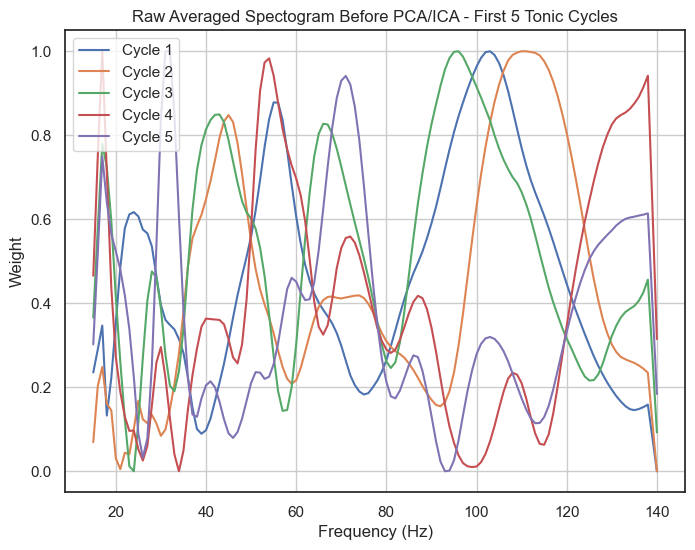

In [23]:
plt.figure(figsize=(8, 6))
for i in range(5): 
    plt.plot(frequencies, all_tonic_sss[i, :], label=f'Cycle {i+1}')
plt.title("Raw Averaged Spectogram Before PCA/ICA - First 5 Tonic Cycles")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.savefig('raw_avg_spectogram_before_pca_ica_tonic.svg')
plt.show()


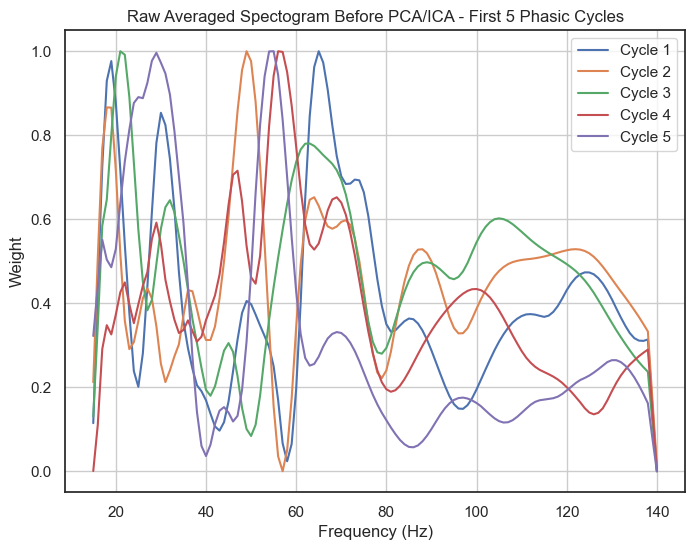

In [64]:
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(frequencies, all_phasic_sss[i, :], label=f'Cycle {i+1}')
plt.title("Raw Averaged Spectogram Before PCA/ICA - First 5 Phasic Cycles")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.savefig('raw_avg_spectogram_before_pca_ica_phasic.svg')
plt.show()


Peak frequency of tSC1: 33 Hz
Peak frequency of tSC2: 63 Hz
Peak frequency of tSC3: 71 Hz
Peak frequency of tSC4: 47 Hz
Peak frequency of tSC5: 77 Hz


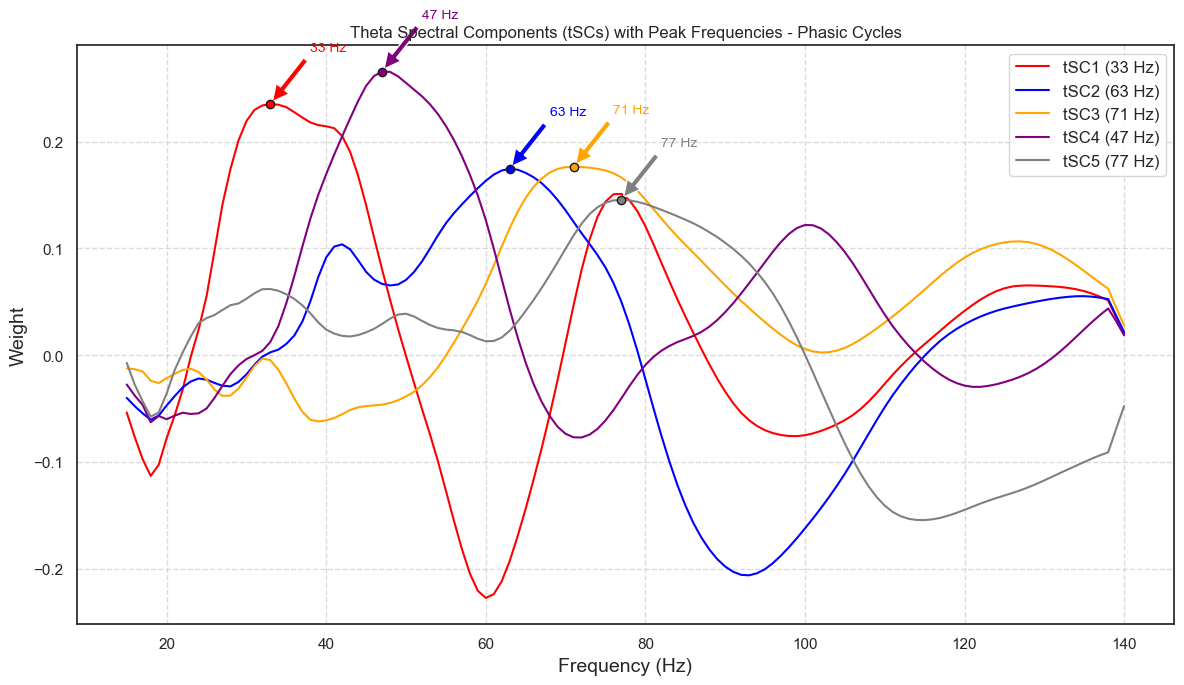

In [65]:
n_components_pca = 5
pca = PCA(n_components=n_components_pca, random_state=0)
pca_result = pca.fit_transform(all_phasic_sss) 

ica = FastICA(n_components=n_components_pca, random_state=0)
tSCs = ica.fit_transform(pca_result)  
ica_components = ica.components_   

tSCs_weights_original = np.dot(ica_components, pca.components_)  

mean_projections = np.dot(tSCs_weights_original, all_phasic_sss.T).mean(axis=1)
for i in range(n_components_pca):
    if mean_projections[i] < 0:
        tSCs_weights_original[i, :] *= -1

peak_frequencies = []
for i in range(n_components_pca):
    idx_peak = np.argmax(tSCs_weights_original[i, :])
    peak_freq = frequencies[idx_peak]
    peak_frequencies.append(peak_freq)
    print(f"Peak frequency of tSC{i+1}: {peak_freq} Hz")

colors = ['red', 'blue', 'orange', 'purple', 'gray']
labels = ['tSC1', 'tSC2', 'tSC3', 'tSC4', 'tSC5']

plt.figure(figsize=(12, 7))

for i in range(n_components_pca):

    plt.plot(frequencies, tSCs_weights_original[i, :], color=colors[i], label=f'{labels[i]} ({peak_frequencies[i]} Hz)')

    plt.scatter(peak_frequencies[i], tSCs_weights_original[i, peak_frequencies[i]-15], color=colors[i], edgecolor='k', zorder=5)

    plt.annotate(f'{peak_frequencies[i]} Hz',
                 xy=(peak_frequencies[i], tSCs_weights_original[i, peak_frequencies[i]-15]),
                 xytext=(peak_frequencies[i]+5, tSCs_weights_original[i, peak_frequencies[i]-15]+0.05),
                 arrowprops=dict(facecolor=colors[i], shrink=0.05),
                 fontsize=10,
                 color=colors[i])

plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Theta Spectral Components (tSCs) with Peak Frequencies - Phasic Cycles', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('spectral_components_phasic_cycle.svg')
plt.show()



Peak frequency of tSC1: 84 Hz
Peak frequency of tSC2: 78 Hz
Peak frequency of tSC3: 127 Hz
Peak frequency of tSC4: 46 Hz
Peak frequency of tSC5: 64 Hz


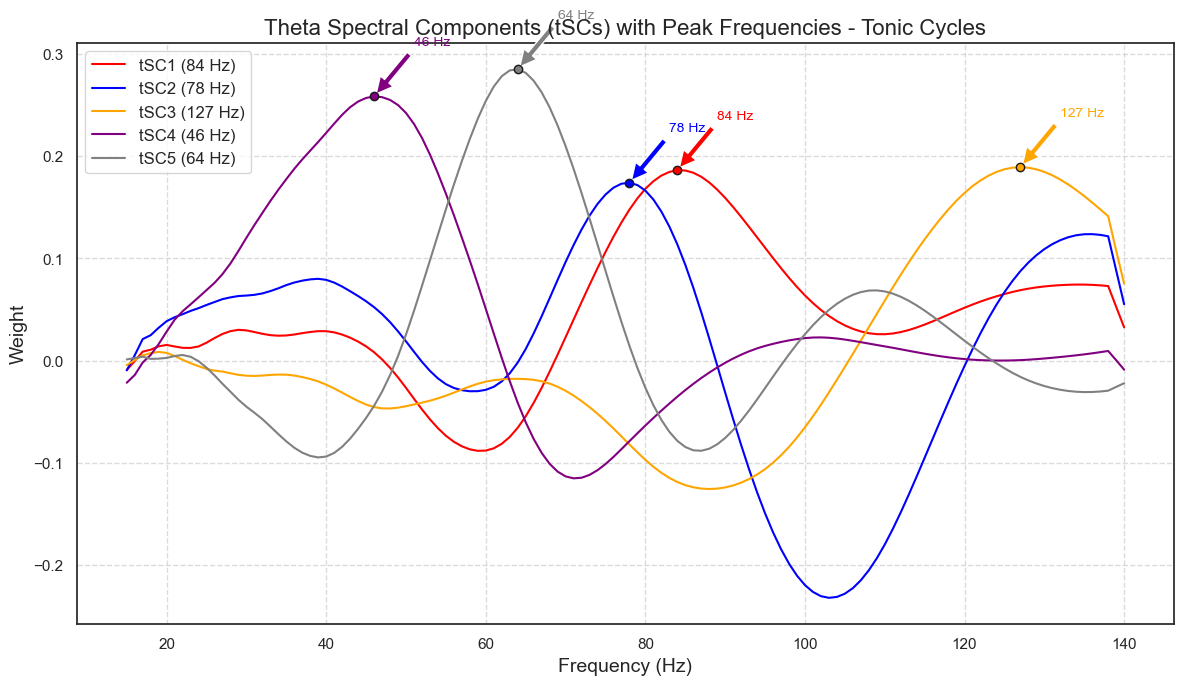

In [66]:
n_components_pca = 5
pca = PCA(n_components=n_components_pca, random_state=0)
pca_result = pca.fit_transform(all_tonic_sss) 

ica = FastICA(n_components=n_components_pca, random_state=0)
tSCs = ica.fit_transform(pca_result) 
ica_components = ica.components_      

tSCs_weights_original = np.dot(ica_components, pca.components_)  

mean_projections = np.dot(tSCs_weights_original, all_phasic_sss.T).mean(axis=1)
for i in range(n_components_pca):
    if mean_projections[i] < 0:
        tSCs_weights_original[i, :] *= -1

peak_frequencies = []
for i in range(n_components_pca):
    idx_peak = np.argmax(tSCs_weights_original[i, :])
    peak_freq = frequencies[idx_peak]
    peak_frequencies.append(peak_freq)
    print(f"Peak frequency of tSC{i+1}: {peak_freq} Hz")

colors = ['red', 'blue', 'orange', 'purple', 'gray']
labels = ['tSC1', 'tSC2', 'tSC3', 'tSC4', 'tSC5']

plt.figure(figsize=(12, 7))

for i in range(n_components_pca):

    plt.plot(frequencies, tSCs_weights_original[i, :], color=colors[i], label=f'{labels[i]} ({peak_frequencies[i]} Hz)')

    plt.scatter(peak_frequencies[i], tSCs_weights_original[i, peak_frequencies[i]-15], color=colors[i], edgecolor='k', zorder=5)

    plt.annotate(f'{peak_frequencies[i]} Hz',
                 xy=(peak_frequencies[i], tSCs_weights_original[i, peak_frequencies[i]-15]),
                 xytext=(peak_frequencies[i]+5, tSCs_weights_original[i, peak_frequencies[i]-15]+0.05),
                 arrowprops=dict(facecolor=colors[i], shrink=0.05),
                 fontsize=10,
                 color=colors[i])

plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Theta Spectral Components (tSCs) with Peak Frequencies - Tonic Cycles', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('spectral_components_tonic_cycle.svg')
plt.show()

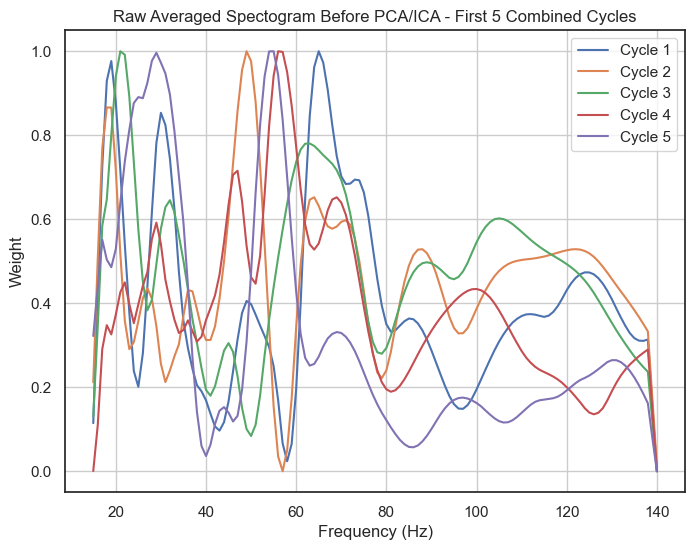

In [25]:
all_FPPs_combined = all_phasic_FPPs + all_tonic_FPPs

all_combined_spectral_signatures = []
for FPP in all_FPPs_combined:
    combined_spectral_signature = extract_spectural_signiture(FPP)
    all_combined_spectral_signatures.append(combined_spectral_signature)

all_combined_sss = []
for ll in all_combined_spectral_signatures:
    for ss in ll:
        all_combined_sss.append(ss)

all_combined_sss = np.array(all_combined_sss)

plt.figure(figsize=(8, 6))
for i in range(5): 
    plt.plot(frequencies, all_combined_sss[i, :], label=f'Cycle {i+1}')
plt.title("Raw Averaged Spectogram Before PCA/ICA - First 5 Combined Cycles")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.savefig('raw_avg_spectogram_before_pca_ica_combined.svg')
plt.show()

Peak frequency of tSC1: 45 Hz
Peak frequency of tSC2: 129 Hz
Peak frequency of tSC3: 79 Hz
Peak frequency of tSC4: 64 Hz
Peak frequency of tSC5: 86 Hz


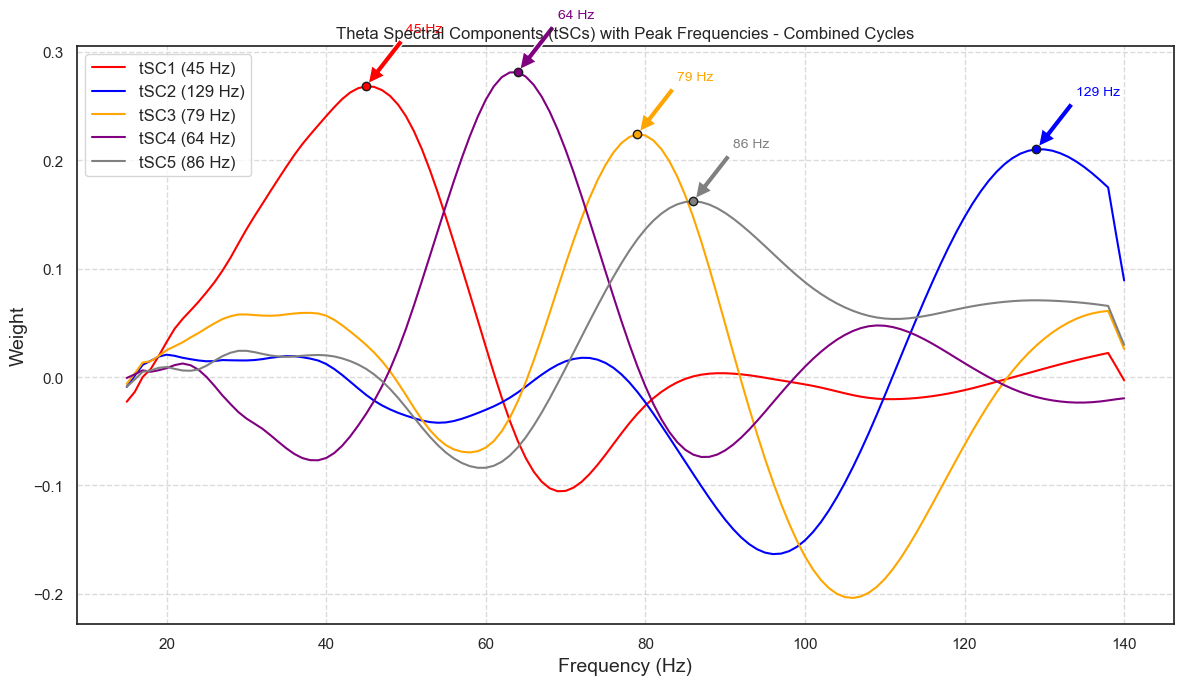

In [29]:
n_components_pca = 5
pca = PCA(n_components=n_components_pca, random_state=42)
pca_result = pca.fit_transform(all_combined_sss) 

ica = FastICA(n_components=n_components_pca, random_state=42)
tSCs = ica.fit_transform(pca_result)  
ica_components = ica.components_   

tSCs_weights_original = np.dot(ica_components, pca.components_)  

mean_projections = np.dot(tSCs_weights_original, all_combined_sss.T).mean(axis=1)
for i in range(n_components_pca):
    if mean_projections[i] < 0:
        tSCs_weights_original[i, :] *= -1

peak_frequencies = []
for i in range(n_components_pca):
    idx_peak = np.argmax(tSCs_weights_original[i, :])
    peak_freq = frequencies[idx_peak]
    peak_frequencies.append(peak_freq)
    print(f"Peak frequency of tSC{i+1}: {peak_freq} Hz")

colors = ['red', 'blue', 'orange', 'purple', 'gray']
labels = ['tSC1', 'tSC2', 'tSC3', 'tSC4', 'tSC5']

plt.figure(figsize=(12, 7))

for i in range(n_components_pca):

    plt.plot(frequencies, tSCs_weights_original[i, :], color=colors[i], label=f'{labels[i]} ({peak_frequencies[i]} Hz)')

    plt.scatter(peak_frequencies[i], tSCs_weights_original[i, peak_frequencies[i]-15], color=colors[i], edgecolor='k', zorder=5)

    plt.annotate(f'{peak_frequencies[i]} Hz',
                 xy=(peak_frequencies[i], tSCs_weights_original[i, peak_frequencies[i]-15]),
                 xytext=(peak_frequencies[i]+5, tSCs_weights_original[i, peak_frequencies[i]-15]+0.05),
                 arrowprops=dict(facecolor=colors[i], shrink=0.05),
                 fontsize=10,
                 color=colors[i])

plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Theta Spectral Components (tSCs) with Peak Frequencies - Combined Cycles', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('spectral_components_phasic_cycle.svg')
plt.show()

# utils

In [ ]:
# version 1

def prepare_data_for_umap(imfs, imf_frequencies):

  waveforms = pd.DataFrame()
  all_trials = pd.DataFrame()
  all_FPPs = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']
    print(len(cycle_data['theta_imf']))
    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
    
    if all_cycles is None or all_cycles.chain_vect.size == 0:
        print("No cycles satisfy the conditions.")
        return pd.DataFrame(), pd.DataFrame(), []
    
    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

    mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

    all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
    all_waveforms = pd.DataFrame(all_waveforms.T)

    waveforms = pd.concat([waveforms, all_waveforms])

    trial = all_cycles.get_metric_dataframe(subset=True)
    trial['mode_freqs'] = mode_freqs
    trial['entropy'] = entropies
    all_trials = pd.concat([all_trials, trial])

  return waveforms, all_trials, all_FPPs